In [40]:
import os
import pandas as pd
from IPython.display import display

# list to summon all files
sampled_dfs = []

# Find the folder
base_dir = os.getcwd()

# Supervise all files
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file == "T_ONTIME_REPORTING.csv":  # Matcher filnavne præcist
            csv_path = os.path.join(root, file)
            try:
                # Robust loading, remove useless data
                try:
                    df = pd.read_csv(csv_path, sep=None, engine="python", encoding="utf-8", on_bad_lines="skip")
                except Exception:
                    df = pd.read_csv(csv_path, sep=None, engine="python", encoding="latin1", on_bad_lines="skip")


                # sample max 300 rows, per. file
                sample_size = min(300, len(df))
                sample = df.sample(sample_size, random_state=42)
                sampled_dfs.append(sample)

                print(f"✅ added correctly: {csv_path} ({sample_size} rows)")

            except Exception as e:
                print(f" incorrect loading {csv_path}: {e}")

# Combine files to a shared dataframe
if sampled_dfs:
    df = pd.concat(sampled_dfs, ignore_index=True)
    print(f"\n📊 final dataset {len(df):,} rows from {len(sampled_dfs)} files.")
    display(df.head())
else:
    print("No file was found")

✅ added correctly: /Users/robinribelrifai/Desktop/Data months/April/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/december/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/february/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/June/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/July/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/August/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/May/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/Oktober/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/November/T_ONTIME_REPORTING.csv (300 rows)
✅ added correctly: /Users/robinribelrifai/Desktop/Data months/January/T_ON

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,...,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,ARR_TIME_BLK,FLIGHTS,DISTANCE
0,2024,4,12,18,3,12/18/2024 12:00:00 AM,1293.0,12892,LAX,California,...,"Seattle, WA",Washington,600,553.0,858.0,846.0,0.0,0800-0859,1.0,954.0
1,2024,4,12,13,5,12/13/2024 12:00:00 AM,3764.0,13930,ORD,Illinois,...,"Indianapolis, IN",Indiana,1338,1336.0,1537.0,1531.0,0.0,1500-1559,1.0,177.0
2,2024,4,12,31,2,12/31/2024 12:00:00 AM,1788.0,14747,SEA,Washington,...,"Houston, TX",Texas,704,701.0,1327.0,1315.0,0.0,1300-1359,1.0,1874.0
3,2024,4,12,22,7,12/22/2024 12:00:00 AM,5487.0,11057,CLT,North Carolina,...,"Jacksonville/Camp Lejeune, NC",North Carolina,2047,2139.0,2156.0,2230.0,1.0,2100-2159,1.0,191.0
4,2024,4,12,13,5,12/13/2024 12:00:00 AM,5374.0,11150,CSG,Georgia,...,"Atlanta, GA",Georgia,1742,1734.0,1845.0,1814.0,0.0,1800-1859,1.0,83.0


In [41]:
# --- Prepare data for Linear regression Model (Leakage-Free Version) ---
# This cell creates the delay target variable and time-based predictors that can be known before departure.

import numpy as np
import pandas as pd

# --- Convert HHMM → minutes since midnight ---
# This function transforms scheduled or actual departure times into total minutes since midnight.
def hhmm_to_minutes(x):
    try:
        x = int(float(str(x).strip()))
        h, m = x // 100, x % 100
        return min(h * 60 + m, 1439)  # cap at 23:59
    except:
        return np.nan

# --- Create minute-based columns for actual and scheduled departure times ---
if "DEP_TIME" in df.columns:
    df["DEP_TIME_MIN"] = df["DEP_TIME"].apply(hhmm_to_minutes)

if "CRS_DEP_TIME" in df.columns:
    df["CRS_DEP_TIME_MIN"] = df["CRS_DEP_TIME"].apply(hhmm_to_minutes)

# --- Calculate delay in minutes (only for creating the target variable) ---
# Note: This column will NOT be used as an input feature to prevent data leakage.
if {"DEP_TIME_MIN", "CRS_DEP_TIME_MIN"}.issubset(df.columns):
    df["DEP_DELAY_MIN"] = df["DEP_TIME_MIN"] - df["CRS_DEP_TIME_MIN"]

print("\n'DEP_DELAY_MIN' successfully calculated.")
display(df[["DEP_TIME_MIN", "CRS_DEP_TIME_MIN", "DEP_DELAY_MIN"]].head())

# --- Create the binary target variable for logistic classification ---
# 1 = delayed more than 15 minutes, 0 = on time
df["DELAYED"] = (df["DEP_DELAY_MIN"] > 15).astype(int)

print("\nTarget variable 'DELAYED' created (1 = delayed, 0 = on time).")
display(df[["DEP_DELAY_MIN", "DELAYED"]].head())

# --- Create cyclic time features for departure time ---
# These encode the time of day in a circular format to capture daily patterns
# (e.g., 23:59 and 00:01 are close in time, not far apart).
if "CRS_DEP_TIME_MIN" in df.columns:
    df["DEP_TIME_sin"] = np.sin(2 * np.pi * df["CRS_DEP_TIME_MIN"] / 1440)
    df["DEP_TIME_cos"] = np.cos(2 * np.pi * df["CRS_DEP_TIME_MIN"] / 1440)
    print("\nCyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.")
    display(df[["CRS_DEP_TIME_MIN", "DEP_TIME_sin", "DEP_TIME_cos"]].head())



'DEP_DELAY_MIN' successfully calculated.


,DEP_TIME_MIN,CRS_DEP_TIME_MIN,DEP_DELAY_MIN
0,353.0,360,-7.0
1,816.0,818,-2.0
2,421.0,424,-3.0
3,1299.0,1247,52.0
4,1054.0,1062,-8.0



Target variable 'DELAYED' created (1 = delayed, 0 = on time).


,DEP_DELAY_MIN,DELAYED
0,-7.0,0
1,-2.0,0
2,-3.0,0
3,52.0,1
4,-8.0,0



Cyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.


,CRS_DEP_TIME_MIN,DEP_TIME_sin,DEP_TIME_cos
0,360,1.000000,6.123234e-17
1,818,-0.414693,-9.099613e-01
2,424,0.961262,-2.756374e-01
3,1247,-0.746057,6.658817e-01
4,1062,-0.996917,-7.845910e-02


In [42]:
# --- Convert DEP_TIME_MIN into 15-minute bins (categorical) ---
df["DEP_TIME_BIN"] = pd.cut(
    df["DEP_TIME_MIN"],
    bins=range(0, 1441, 15),
    labels=[f"{h:02d}:{m:02d}" for h in range(24) for m in range(0, 60, 15)]
)

print("\n🕒 Sample of 15-minute bins:")
display(df[["DEP_TIME_MIN", "DEP_TIME_BIN"]].head())

# --- Select model features ---
selected_features = ["MONTH",         
    "DAY_OF_WEEK",  
    "DAY_OF_MONTH",
    "DISTANCE",       
    "ORIGIN",        
    "DEST", 
    "DEP_TIME_sin",   
    "DEP_TIME_cos",   
    "OP_CARRIER_FL_NUM"]

# --- Keep only relevant rows (drop NaN) ---
df_model = df[selected_features + ["DELAYED"]].dropna()

X = df_model[selected_features]
y = df_model["DELAYED"]

print(f"\n📊 Final dataset ready for modeling: {len(X)} rows, {len(selected_features)} features.")
display(X.head())


🕒 Sample of 15-minute bins:


,DEP_TIME_MIN,DEP_TIME_BIN
0,353.0,05:45
1,816.0,13:30
2,421.0,07:00
3,1299.0,21:30
4,1054.0,17:30



📊 Final dataset ready for modeling: 3600 rows, 9 features.


,MONTH,DAY_OF_WEEK,DAY_OF_MONTH,DISTANCE,ORIGIN,DEST,DEP_TIME_sin,DEP_TIME_cos,OP_CARRIER_FL_NUM
0,12,3,18,954.0,LAX,SEA,1.000000,6.123234e-17,1293.0
1,12,5,13,177.0,ORD,IND,-0.414693,-9.099613e-01,3764.0
2,12,2,31,1874.0,SEA,IAH,0.961262,-2.756374e-01,1788.0
3,12,7,22,191.0,CLT,OAJ,-0.746057,6.658817e-01,5487.0
4,12,5,13,83.0,CSG,ATL,-0.996917,-7.845910e-02,5374.0


Dataset for linear regression: 3546 rows
Train size: 2836 | Test size: 710

--- Linear Regression Performance (Delay in Minutes) ---
Baseline → RMSE: 44.06 | R²: -0.001
Ridge    → RMSE: 44.10 | R²: -0.003
Lasso    → RMSE: 44.03 | R²: 0.000


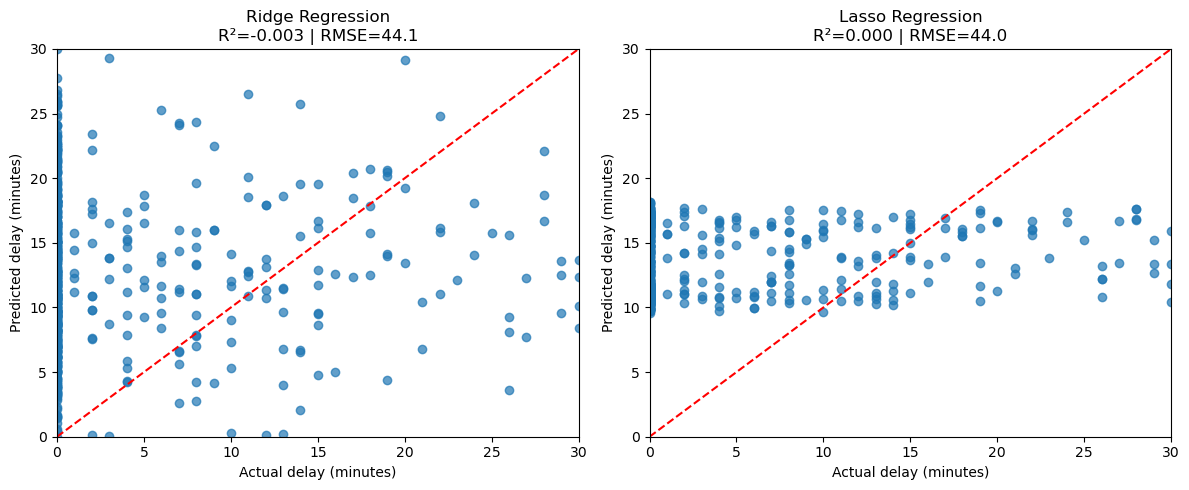

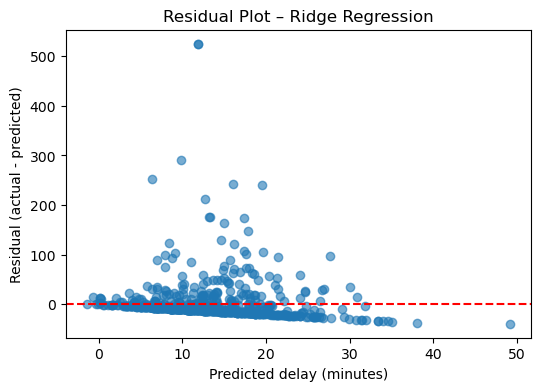

,Model,RMSE (min),R²,Alpha
0,Baseline (Mean),44.055673,-0.000571,nan
1,Ridge,44.098392,-0.002513,30.000000
2,Lasso,44.034754,0.000379,1.000000


In [46]:
# =========================================================
# LINEAR REGRESSION (CLEAN & ALIGNED)
# Target: delay in minutes
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display

# ---------------------------------------------------------
# 1. DEFINE CONTINUOUS TARGET (LEAKAGE-FREE)
# ---------------------------------------------------------

df["target_delay_min"] = np.clip(
    df["DEP_TIME_MIN"] - df["CRS_DEP_TIME_MIN"],
    a_min=0,
    a_max=None
)

df_model = df.dropna(subset=["target_delay_min"]).copy()

# ---------------------------------------------------------
# 2. DEFINE FEATURES (CORRECT SPLIT)
# ---------------------------------------------------------

numeric_features = [
    "MONTH",
    "DAY_OF_WEEK",
    "DISTANCE",
    "DEP_TIME_sin",
    "DEP_TIME_cos",
    "OP_CARRIER_FL_NUM"
]

categorical_features = [
    "ORIGIN",
    "DEST"
]

# Keep only columns that exist
numeric_features = [c for c in numeric_features if c in df_model.columns]
categorical_features = [c for c in categorical_features if c in df_model.columns]

X = df_model[numeric_features + categorical_features]
y = df_model["target_delay_min"].astype(float)

print(f"Dataset for linear regression: {len(X)} rows")

# ---------------------------------------------------------
# 3. TRAIN / TEST SPLIT
# ---------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

# ---------------------------------------------------------
# 4. PREPROCESSING (USED IN LINEAR REGRESSION)
# ---------------------------------------------------------

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# ---------------------------------------------------------
# 5. MODELS
# ---------------------------------------------------------

# Baseline
pipe_dummy = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DummyRegressor(strategy="mean"))
])

# Ridge
pipe_ridge = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RidgeCV(
        alphas=[0.1, 1, 3, 10, 30],
        cv=5,
        scoring="neg_mean_squared_error"
    ))
])

# Lasso
pipe_lasso = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LassoCV(
        alphas=[0.1, 1, 3, 10, 30],
        cv=5,
        random_state=42,
        max_iter=10000
    ))
])

# ---------------------------------------------------------
# 6. FIT MODELS
# ---------------------------------------------------------

pipe_dummy.fit(X_train, y_train)
pipe_ridge.fit(X_train, y_train)
pipe_lasso.fit(X_train, y_train)

y_pred_dummy = pipe_dummy.predict(X_test)
y_pred_ridge = pipe_ridge.predict(X_test)
y_pred_lasso = pipe_lasso.predict(X_test)

# ---------------------------------------------------------
# 7. EVALUATION
# ---------------------------------------------------------

rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

r2_dummy = r2_score(y_test, y_pred_dummy)
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("\n--- Linear Regression Performance (Delay in Minutes) ---")
print(f"Baseline → RMSE: {rmse_dummy:.2f} | R²: {r2_dummy:.3f}")
print(f"Ridge    → RMSE: {rmse_ridge:.2f} | R²: {r2_ridge:.3f}")
print(f"Lasso    → RMSE: {rmse_lasso:.2f} | R²: {r2_lasso:.3f}")

# ---------------------------------------------------------
# 8. VISUALIZATION (ZOOMED)
# ---------------------------------------------------------

max_minutes = 30
plt.figure(figsize=(12,5))

# Ridge
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_ridge, alpha=0.7)
plt.plot([0, max_minutes], [0, max_minutes], "r--")
plt.xlim(0, max_minutes)
plt.ylim(0, max_minutes)
plt.xlabel("Actual delay (minutes)")
plt.ylabel("Predicted delay (minutes)")
plt.title(f"Ridge Regression\nR²={r2_ridge:.3f} | RMSE={rmse_ridge:.1f}")

# Lasso
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_lasso, alpha=0.7)
plt.plot([0, max_minutes], [0, max_minutes], "r--")
plt.xlim(0, max_minutes)
plt.ylim(0, max_minutes)
plt.xlabel("Actual delay (minutes)")
plt.ylabel("Predicted delay (minutes)")
plt.title(f"Lasso Regression\nR²={r2_lasso:.3f} | RMSE={rmse_lasso:.1f}")

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 9. RESIDUAL PLOT (RIDGE)
# ---------------------------------------------------------

residuals_ridge = y_test - y_pred_ridge

plt.figure(figsize=(6,4))
plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted delay (minutes)")
plt.ylabel("Residual (actual - predicted)")
plt.title("Residual Plot – Ridge Regression")
plt.show()

# ---------------------------------------------------------
# 10. SUMMARY TABLE
# ---------------------------------------------------------

summary = pd.DataFrame({
    "Model": ["Baseline (Mean)", "Ridge", "Lasso"],
    "RMSE (min)": [rmse_dummy, rmse_ridge, rmse_lasso],
    "R²": [r2_dummy, r2_ridge, r2_lasso],
    "Alpha": [
        None,
        pipe_ridge.named_steps["model"].alpha_,
        pipe_lasso.named_steps["model"].alpha_
    ]
})

display(summary.style.set_caption("📊 Linear Regression Results (Delay in Minutes)"))


In [26]:
# Add holiday attribute
df['Holiday?'] = (
    ((df['MONTH'] == 12) & (df['DAY_OF_MONTH'] >= 20)) |  # Dec 20–31
    ((df['MONTH'] == 1) & (df['DAY_OF_MONTH'] <= 5))   |  # Jan 1–5
    (df['MONTH'].isin([7, 8]))                           # July & August
)
# Filtrér så vi kun viser data fra holiday-perioden
df = df[df["Holiday?"] == True]
df

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,...,DISTANCE,DEP_TIME_MIN,CRS_DEP_TIME_MIN,DEP_DELAY_MIN,DELAYED,DEP_TIME_sin,DEP_TIME_cos,DEP_TIME_BIN,target_delay_min,Holiday?
2,2024,4,12,31,2,12/31/2024 12:00:00 AM,1788.0,14747,SEA,Washington,...,1874.0,421.0,424,-3.0,0,0.961262,-0.275637,07:00,0.0,True
3,2024,4,12,22,7,12/22/2024 12:00:00 AM,5487.0,11057,CLT,North Carolina,...,191.0,1299.0,1247,52.0,1,-0.746057,0.665882,21:30,52.0,True
5,2024,4,12,25,3,12/25/2024 12:00:00 AM,3176.0,11298,DFW,Texas,...,986.0,576.0,585,-9.0,0,0.555570,-0.831470,09:30,0.0,True
6,2024,4,12,28,6,12/28/2024 12:00:00 AM,4284.0,10423,AUS,Texas,...,189.0,1182.0,1130,52.0,1,-0.976296,0.216440,19:30,52.0,True
10,2024,4,12,25,3,12/25/2024 12:00:00 AM,1539.0,14908,SNA,California,...,2099.0,518.0,520,-2.0,0,0.766044,-0.642788,08:30,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,2024,3,8,15,4,8/15/2024 12:00:00 AM,714.0,14747,SEA,Washington,...,1050.0,756.0,764,-8.0,0,-0.190809,-0.981627,12:30,0.0,True
3296,2024,3,8,14,3,8/14/2024 12:00:00 AM,6208.0,10372,ASE,Colorado,...,701.0,856.0,868,-12.0,0,-0.601815,-0.798636,14:15,0.0,True
3297,2024,3,8,21,3,8/21/2024 12:00:00 AM,5458.0,10980,CHA,Tennessee,...,241.0,646.0,658,-12.0,0,0.267238,-0.963630,10:45,0.0,True
3298,2024,3,8,29,4,8/29/2024 12:00:00 AM,2337.0,14100,PHL,Pennsylvania,...,453.0,561.0,574,-13.0,0,0.594823,-0.803857,09:15,0.0,True


In [27]:
# --- Create sine and cosine features for departure time ---
# Converts the time of day (in minutes) into circular values between -1 and 1
# This allows the model to understand the cyclical nature of time (e.g. 23:59 and 00:01 are close).

import numpy as np

if "DEP_TIME_MIN" in df.columns:
    df["DEP_TIME_sin"] = np.sin(2 * np.pi * df["DEP_TIME_MIN"].fillna(0) / 1440)
    df["DEP_TIME_cos"] = np.cos(2 * np.pi * df["DEP_TIME_MIN"].fillna(0) / 1440)
    print("Cyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.")
else:
    print("Error: Column 'DEP_TIME_MIN' not found. Make sure it is created before running this cell.")

display(df[["DEP_TIME_MIN", "DEP_TIME_sin", "DEP_TIME_cos"]].head())

Cyclic time features 'DEP_TIME_sin' and 'DEP_TIME_cos' created successfully.


,DEP_TIME_MIN,DEP_TIME_sin,DEP_TIME_cos
2,421.0,0.964787,-0.263031
3,1299.0,-0.577145,0.816642
5,576.0,0.587785,-0.809017
6,1182.0,-0.902585,0.430511
10,518.0,0.771625,-0.636078


Holiday dataset: 466 rows out of 3600 total
Dataset for holiday regression: 458 rows
Train size: 366 | Test size: 92

--- Holiday Linear Regression Performance ---
Baseline → RMSE: 57.70 | R²: -0.019
Ridge    → RMSE: 57.27 | R²: -0.004
Lasso    → RMSE: 57.70 | R²: -0.019


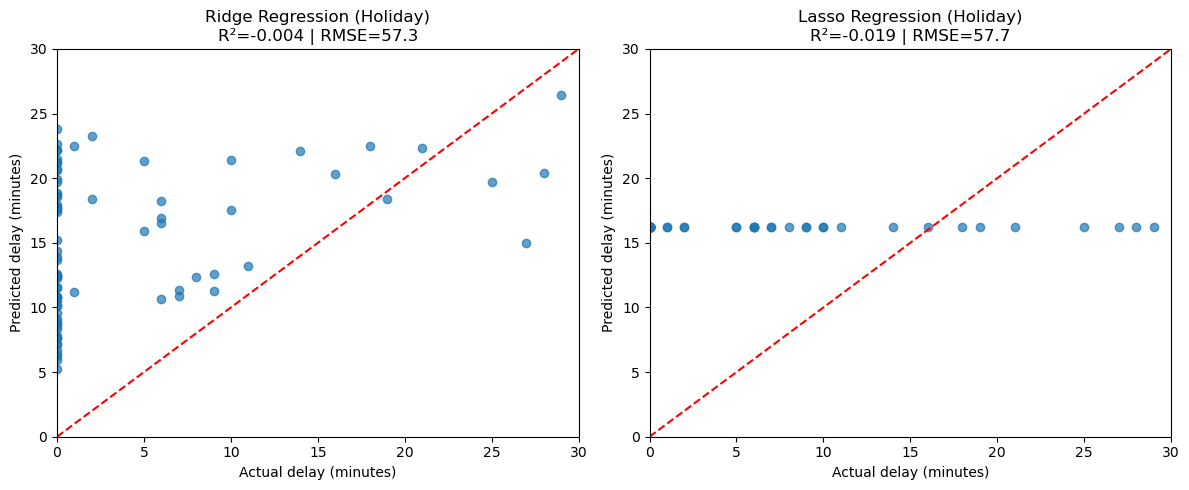

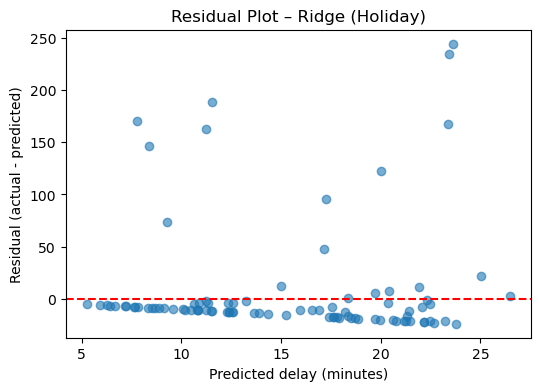

,Model,RMSE (min),R²,Alpha
0,Baseline (Mean),57.696424,-0.019112,NaN
1,Ridge,57.269803,-0.004097,100.0
2,Lasso,57.696424,-0.019112,30.0


In [37]:
# LINEAR REGRESSION – HOLIDAY FLIGHTS Attribute
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score


# 1. HOLIDAY ATTRIBUTE 
df["Holiday"] = (
    ((df["MONTH"] == 12) & (df["DAY_OF_MONTH"] >= 20)) |
    ((df["MONTH"] == 1) & (df["DAY_OF_MONTH"] <= 5)) |
    (df["MONTH"].isin([7, 8]))
)

# Keep only holiday flights
df_holiday = df[df["Holiday"] == True].copy()
print(f"Holiday dataset: {len(df_holiday)} rows out of {len(df)} total")


# 2. TARGET VARIABLE (continuous, leakage-free)
df_holiday["TARGET_DELAY_MIN"] = np.clip(
    df_holiday["DEP_TIME_MIN"] - df_holiday["CRS_DEP_TIME_MIN"],
    a_min=0,
    a_max=None
)


# 3. FEATURES (aligned with previous regression)
numeric_features = [
    "MONTH",
    "DAY_OF_WEEK",
    "DAY_OF_MONTH",
    "DISTANCE",
    "DEP_TIME_sin",
    "DEP_TIME_cos"
]

categorical_features = ["ORIGIN", "DEST"]

df_holiday = df_holiday.dropna(
    subset=numeric_features + categorical_features + ["TARGET_DELAY_MIN"]
)

X = df_holiday[numeric_features + categorical_features]
y = df_holiday["TARGET_DELAY_MIN"].astype(float)

print(f"Dataset for holiday regression: {len(X)} rows")


# 4. TRAIN / TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")


# 5. PREPROCESSING
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])


# 6. MODELS
# Baseline
pipe_dummy = Pipeline([
    ("preprocessor", preprocessor),
    ("model", DummyRegressor(strategy="mean"))
])

# Ridge
pipe_ridge = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RidgeCV(
        alphas=[0.1, 1, 10, 30, 100],
        cv=5,
        scoring="r2"
    ))
])

# Lasso
pipe_lasso = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LassoCV(
        alphas=[0.1, 1, 10, 30],
        cv=5,
        max_iter=10000,
        random_state=42
    ))
])

# ---------------------------------------------------------
# 7. FIT MODELS
# ---------------------------------------------------------
pipe_dummy.fit(X_train, y_train)
pipe_ridge.fit(X_train, y_train)
pipe_lasso.fit(X_train, y_train)

y_pred_dummy = pipe_dummy.predict(X_test)
y_pred_ridge = pipe_ridge.predict(X_test)
y_pred_lasso = pipe_lasso.predict(X_test)

# ---------------------------------------------------------
# 8. EVALUATION
# ---------------------------------------------------------
rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

r2_dummy = r2_score(y_test, y_pred_dummy)
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("\n--- Holiday Linear Regression Performance ---")
print(f"Baseline → RMSE: {rmse_dummy:.2f} | R²: {r2_dummy:.3f}")
print(f"Ridge    → RMSE: {rmse_ridge:.2f} | R²: {r2_ridge:.3f}")
print(f"Lasso    → RMSE: {rmse_lasso:.2f} | R²: {r2_lasso:.3f}")


# 9. VISUALIZATION 

max_minutes = 30

plt.figure(figsize=(12,5))

# Ridge
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_ridge, alpha=0.7)
plt.plot([0, max_minutes], [0, max_minutes], "r--")
plt.xlim(0, max_minutes)
plt.ylim(0, max_minutes)
plt.xlabel("Actual delay (minutes)")
plt.ylabel("Predicted delay (minutes)")
plt.title(f"Ridge Regression (Holiday)\nR²={r2_ridge:.3f} | RMSE={rmse_ridge:.1f}")

# Lasso
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_lasso, alpha=0.7)
plt.plot([0, max_minutes], [0, max_minutes], "r--")
plt.xlim(0, max_minutes)
plt.ylim(0, max_minutes)
plt.xlabel("Actual delay (minutes)")
plt.ylabel("Predicted delay (minutes)")
plt.title(f"Lasso Regression (Holiday)\nR²={r2_lasso:.3f} | RMSE={rmse_lasso:.1f}")

plt.tight_layout()
plt.show()


# 10. RESIDUAL PLOT (Ridge) - as it showed the best results

residuals_ridge = y_test - y_pred_ridge

plt.figure(figsize=(6,4))
plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted delay (minutes)")
plt.ylabel("Residual (actual - predicted)")
plt.title("Residual Plot – Ridge (Holiday)")
plt.show()

# 11. SUMMARY TABLE

summary = pd.DataFrame({
    "Model": ["Baseline (Mean)", "Ridge", "Lasso"],
    "RMSE (min)": [rmse_dummy, rmse_ridge, rmse_lasso],
    "R²": [r2_dummy, r2_ridge, r2_lasso],
    "Alpha": [
        None,
        pipe_ridge.named_steps["model"].alpha_,
        pipe_lasso.named_steps["model"].alpha_
    ]
})

summary
